# MAPIE - How to use MAPIE for your own model
## Use Case: Intent Classification with a LM BERT model from Transformers HF package

The use case we are dealing with here is as follows: a language model is used to detect the user's intent/command to automate an action (as might be expected of a personal assistant/home automation system).

The challenge is then to be certain of the user's action to avoid triggering unwanted actions. Indeed, if the language model is uncertain, we ask the user for clarification. The constraint is to solicit the user as little as possible to make the experience more fluid.

The model and dataset chosen do not come from a home automation system but do the job for the purposes of this tutorial.
***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import copy, deepcopy

import warnings
warnings.filterwarnings("ignore")

from utils.config import SMALL_FIGSIZE, MEDIUM_FIGSIZE, LARGE_FIGSIZE
sns.set_palette('tab20c')

np.random.seed(42)

### I) Obtain data and split it into train, calibration and validation datasets

In [2]:
from datasets import load_dataset
from utils.data.dnd_style_intents import sample_and_split_dataset, get_dataframe, get_X_y
from utils.data.dnd_style_intents import FEATURES, LABEL, TARGET, PREDICTION, SET, SET_LABEL


nb_train, nb_calib, nb_test = 1000, 200, 250

dataset = load_dataset("neurae/dnd_style_intents")
ds_train, ds_calib, ds_test = sample_and_split_dataset(dataset, nb_calib=nb_calib, nb_test=nb_test)
df_train, df_calib, df_test = get_dataframe(ds_train, ds_calib, ds_test)
(X_train, y_train), (X_calib, y_calib), (X_test, y_test) = get_X_y(df_train, df_calib, df_test)

Using the latest cached version of the dataset since neurae/dnd_style_intents couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/thibaultcordier/.cache/huggingface/datasets/neurae___dnd_style_intents/default/0.0.0/f070d66ac5646ad079ad5ac30a4ab88d1497bc61 (last modified on Fri Sep  6 18:11:01 2024).


### II) Obain the LM BERT model

In [3]:
from transformers import pipeline
from utils.data.dnd_style_intents import get_label_mapping

pipe = pipeline("text-classification", model="neurae/bert-dnd-intents", device=0)
idx2lab, lab2idx, label_list = get_label_mapping(df_train)

### III) Show an inference with the LM BERT model

In [4]:
# Show some examples
X_instr = 'Could you send these metting details at 6pm?'
y_pred_instr = pipe(X_instr, top_k=2)
print(y_pred_instr)

[{'label': 'Message', 'score': 0.9945846199989319}, {'label': 'Exchange', 'score': 0.0019817615393549204}]


***
## MAPIE: model training, calibration and prediction (MAPIE/scikit-learn routine)
### 1) Run the 4 steps of the MAPIE routine

The MAPIE routine is composed of 4 steps:
1. Identify a (pre-trained) model.
2. Wrap it with the MAPIE class:
   - Choose the non-conformity score.
   - and compute conformity scores on calibration data.
3. Predict the target on the test data to obtain the prediction sets.

This routine is comparable to that of any scikit-learn-compatible estimator.

In [5]:
import numpy as np
from mapie.classification import MapieClassifier
from mapie.mondrian import MondrianCP
from mapie.conformity_scores import LACConformityScore
from utils.model import MapieFromTransformers


# 1) Get main predictor.
kwargs_predictor={'lab2idx': lab2idx}
clf = MapieFromTransformers(estimator=pipe, **kwargs_predictor)

# 2) Get the non-conformity score.
kwargs_score={}
csf = LACConformityScore(**kwargs_score)


# 3) Conformalize the main predictor (wrap with MAPIE conformal class).
kwargs_conformalizer={'conformity_score': csf, 'cv': 'prefit'}  # split conformal setting
mapie_classifier = MondrianCP(MapieClassifier(estimator=clf, **kwargs_conformalizer))
mapie_classifier = mapie_classifier.fit(
    X_calib, y_calib,
    partition=clf.predict(X_calib)
)

# 4) Obtain predictions and sets of predictions.
alpha = 0.2
alpha_list = np.array([alpha])
kwargs_predict = {}  # {'include_last_label': 'randomized'}
y_pred, y_pis = mapie_classifier.predict(
    X_test, alpha=alpha_list,
    partition=clf.predict(X_test),
    **kwargs_predict
)
y_proba = clf.predict_proba(X_test)

### 2) Visualise the results

In [6]:
# See a picture of the predictions made by the LM BERT model
# Get all the results in a dataframe
pd_results = pd.DataFrame({
    FEATURES: df_test[FEATURES],
    TARGET: df_test[TARGET],
    LABEL: df_test[LABEL],
    PREDICTION: y_pred,
    'pred_names': [idx2lab[y] for y in y_pred],
    'y_test_proba': np.take_along_axis(np.array(y_proba), np.array(y_test).reshape(-1, 1), axis=1)[:,0],
    'y_pred_proba': np.take_along_axis(np.array(y_proba), np.array(y_pred, dtype=int).reshape(-1, 1), axis=1)[:,0],
    'width': np.sum(y_pis[:,:,0], axis=-1),
    'covered': np.take_along_axis(np.array(y_pis[:,:,0]), np.array(y_test, dtype=int).reshape(-1, 1), axis=1)[:,0]
})
pd_results

,examples,labels,label_names,predictions,pred_names,y_test_proba,y_pred_proba,width,covered
0,Your business is to carry socks to workers.,9,Deliver,9.0,Deliver,0.999619,0.999619,1.0,1.0
1,Your target is to deliver knife to Hargrimm th...,9,Deliver,9.0,Deliver,0.999543,0.999543,1.0,1.0
2,Could you deliver report to workers?,7,Message,7.0,Message,0.999637,0.999637,1.0,1.0
3,Can you take agility poition to Alaric Wiseham...,9,Deliver,9.0,Deliver,0.999639,0.999639,1.0,1.0
4,I finished my task in Faeglenest.,1,Complete quest,1.0,Complete quest,0.999901,0.999901,1.0,1.0
...,...,...,...,...,...,...,...,...,...
245,wizard hundred mxcvxjjjfsk hunter bfdbf geniou...,10,Drival,10.0,Drival,0.999766,0.999766,1.0,1.0
246,"Welcome to Sara Starwatcher's world, friends!",15,Greeting,15.0,Greeting,0.997794,0.997794,1.0,1.0
247,"Give me shuriken, scythe.",11,Exchange,11.0,Exchange,0.999023,0.999023,0.0,0.0
248,bring report over to that gnome.,7,Message,7.0,Message,0.999682,0.999682,1.0,1.0


### 3) Visualise the empirical distribution of prediction sets sizes

In [7]:
# Round alpha to the closest value in the list
alpha_dict = {np.round(alpha, 2): i for i, alpha in enumerate(alpha_list)}
# Compute alpha correction (adjust alpha w.r.t quantile correction)
alpha_cor_list = 1-np.clip(np.ceil((1-alpha_list)*(nb_calib+1))/nb_calib, a_min=0, a_max=1)

# Select alpha, index and correction for the following plots
alpha = 0.2
alpha_idx = alpha_dict[alpha]
alpha_cor = alpha_cor_list[alpha_idx]

Now, we propose to visualise the empirical distribution of prediction sets sizes

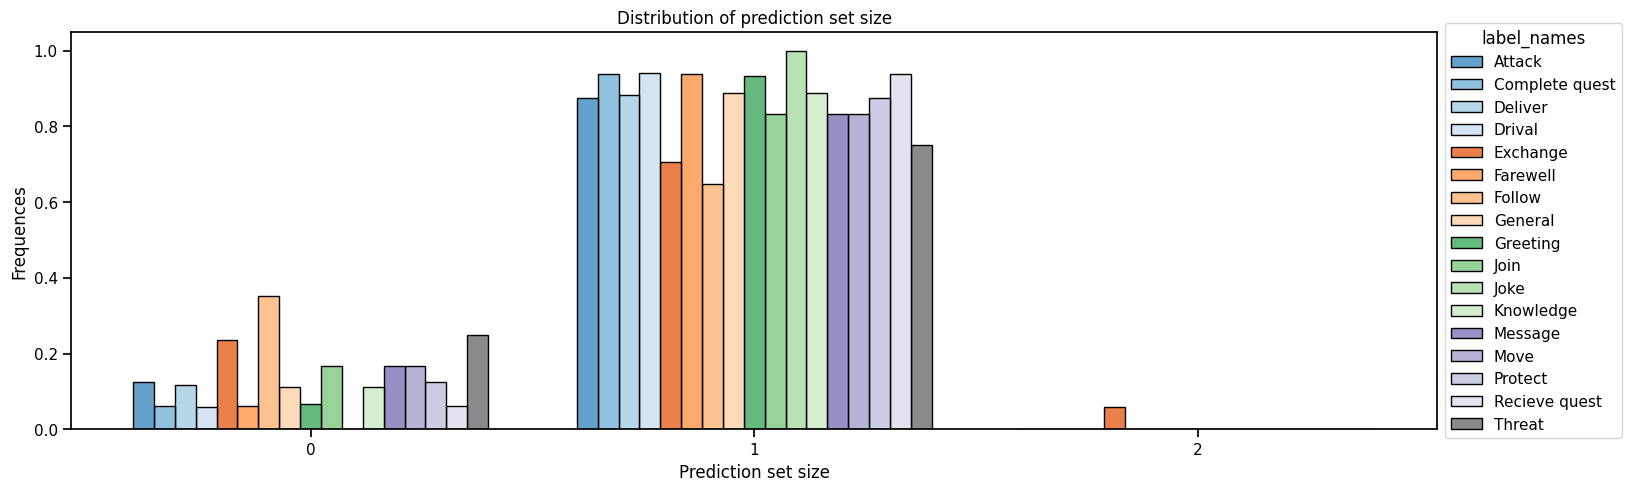

In [8]:
from utils.plot import plot_size_set_distribution

# Sort DataFrame by label names
pd_results = pd_results.sort_values(by=[LABEL])

# Get the size of the prediction sets for each test sample
size_sets = np.sum(y_pis[:,:,alpha_idx], axis=-1)
pd_results['size_set'] = size_sets

# Plot the empirical distribution of the size of the prediction sets
kwargs = {'discrete': True, 'multiple': 'dodge', 'shrink': 0.8}
plot_size_set_distribution(pd_results, label=LABEL, figsize=LARGE_FIGSIZE, hue=LABEL, **kwargs)

### 4) Visualize the coverage by group, do we see any disparities between groups

In [9]:
from sklearn.metrics import accuracy_score
from mapie.metrics import classification_coverage_score, classification_mean_width_score

coverage_ = []
accuracy_ = []
set_size_ = []
number_obs_ = []

idx_size_ = [idx for idx, item in enumerate(pd_results[LABEL])]
y_test_ = pd_results[TARGET][idx_size_]
y_preds_ = pd_results[PREDICTION][idx_size_]
y_pss_ = y_pis[idx_size_, :, 0]

number_obs_.append(len(idx_size_))
accuracy_.append(accuracy_score(y_test_, y_preds_))
coverage_.append(classification_coverage_score(y_test_, y_pss_))
set_size_.append(classification_mean_width_score(y_pss_))

# Compute metrics for each group (coverage, accuracy, number of observations)
for label in np.sort(label_list):
    idx_size_ = [idx for idx, item in enumerate(pd_results[LABEL]) if item == label]
    y_test_ = pd_results[TARGET][idx_size_]
    y_preds_ = pd_results[PREDICTION][idx_size_]
    y_pss_ = y_pis[idx_size_, :, 0]

    number_obs_.append(len(idx_size_))
    accuracy_.append(accuracy_score(y_test_, y_preds_))
    coverage_.append(classification_coverage_score(y_test_, y_pss_))
    set_size_.append(classification_mean_width_score(y_pss_))


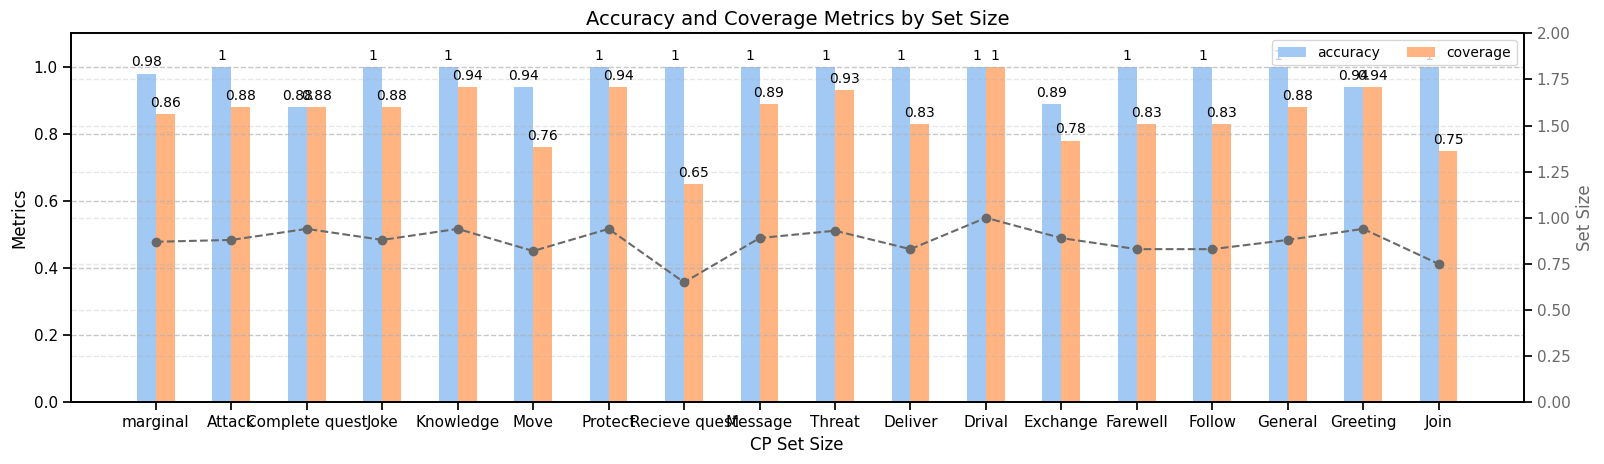

In [10]:
from utils.plot import plot_metrics_inside_groups

metrics = {
    'accuracy': tuple(np.round(accuracy_, 2)),
    'coverage': tuple(np.round(coverage_, 2)),
    'set size': tuple(np.round(set_size_, 2)),
}

# Plot metrics for each group (coverage, accuracy, number of observations)
plot_metrics_inside_groups(metrics, ['marginal'] + label_list, number_obs_, figsize=LARGE_FIGSIZE)